In [21]:
import enum
from random import shuffle
import numpy as np
import tensorflow as tf
from models import perception as pc
from models import dynamics as dy
from dataset import *
import keras.layers as layers
from absl import app
from absl import flags
import loss

In [2]:
def concat_frames_horizontally(v):
  """Arrange a video as horizontally aligned frames."""
  num_frames = v.shape[0]
  # num_frames = 5
  # [F, H, W, C] --> [H, W*F, C].
  return np.concatenate([v[x] for x in range(num_frames)], axis=1)

def describe(d):
  """Describe the contents of a dict of np arrays."""
  for k, v in d.items():
    print(f'\'{k}\' has shape: {v.shape}')
    print(f'===================')
    print(f'min: {v.min()}, max: {v.max()}, type: {v.dtype}\n')

def colorize_mask(m):
  """Adds color channel to mask of unique object ids."""
  """
  input: m: [num_frames,height, width]
  """
  c_m = np.expand_dims(m, axis=-1)
  # c_m = np.squeeze(c_m)
  min_val = np.max(c_m)
  max_val = np.min(c_m)
  # Use three different mappings into range [0-1] to form color.
  c1 = (c_m - min_val)/(max_val - min_val)
  c2 = np.abs((c_m - max_val)/(min_val - max_val))
  c3 = (c1+c2)/2.
  mask = np.concatenate([c1, c2, c3], axis=-1)
  return mask

def colorize_segmask(m):
  """
  add color channel to mask of 

  Args:
      m (num_frames,height, width, num_slots): mask after one-hot encoding
  """
  t, h, w, n = m.shape
  value = tf.constant(range(n), dtype = tf.float32)
  value = tf.expand_dims(tf.expand_dims(tf.expand_dims(value, axis = 0),axis=0),axis=0)
  value = tf.tile(value, multiples=[t, h, w, 1])
  m = m * value
  m = tf.reduce_sum(m, axis = -1)
  return colorize_mask(m)
    

def plot_video(v, name=''):
  """Plots something of the form [num_frames, height, width, channel]."""
  num_frames = v.shape[0]
  width = v.shape[2]
  v = concat_frames_horizontally(v)
  plt.figure(figsize=(30,5))
  plt.imshow(v)
  plt.xticks(ticks=[i*width+width/2 for i in range(num_frames)],
            labels=range(1,num_frames+1))
  plt.yticks([])
  plt.xlabel('Frame Number')
  plt.title(name)
  plt.show()

In [3]:
batch_size = 5
num_frames = 15
num_slots = 8
# mlp_layers = FLAGS.mlp_layers
slot_size = 16

In [4]:
train_ds = make_latent2_dataset(is_train = True, shuffle = True)
train_ds = train_ds.batch(batch_size)
perception = pc.ComponentVAE(input_channels = 3,
                                       height= 64, width = 64, latent_dim = slot_size)
# set the checkpoint
ckpt_e = tf.train.Checkpoint(network=perception)
ckpt_manager_e = tf.train.CheckpointManager(checkpoint=ckpt_e,
                                          directory="/home/stu4/wlg/PLATO/checkpoint/perception/num_slot_8/slot_size_16_learning_rate_0.0004_",
                                          max_to_keep = 5)
checkpoint_path = "/home/stu4/wlg/PLATO/checkpoint/perception"
ckpt_e.restore(ckpt_manager_e.latest_checkpoint)

2022-08-26 11:05:46.904110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-26 11:05:47.299198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22126 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


2022-08-26 11:05:48.782165: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-08-26 11:05:50.166341: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


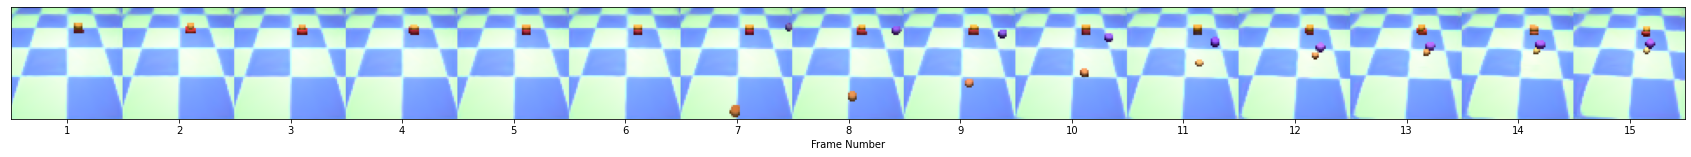

In [5]:
train_example = next(iter(train_ds))
pred_video, pred_mask = pc.video_decoding(perception, train_example['latent'])
video = tf.reduce_sum(pred_video[0], axis = -1)
plot_video(video)

In [6]:
lstm = dy.InteractionLSTM(num_slots, slot_size, use_camera = True)
optimizer = tf.keras.optimizers.Adam(0.0001, epsilon=1e-08)
global_step = tf.Variable(0,
                              trainable=False,
                              name="global_step",
                              dtype=tf.int64)
ckpt = tf.train.Checkpoint(network=lstm,
                                   optimizer=optimizer,
                                   global_step=global_step)
ckpt_manager = tf.train.CheckpointManager(checkpoint=ckpt,
                                             directory='/home/stu4/wlg/PLATO/checkpoint/dynamics/num_slot_8/slot_size_16_learning_rate_0.0001_',
                                             max_to_keep = 5)
ckpt.restore(ckpt_manager.latest_checkpoint)
print("load from checkpoint: {}".format(ckpt_manager.latest_checkpoint))

load from checkpoint: /home/stu4/wlg/PLATO/checkpoint/dynamics/num_slot_8/slot_size_16_learning_rate_0.0001_/ckpt-53


In [7]:
pred_latent_code = lstm(train_example['latent'], train_example['camera_pose'])

In [8]:
loss.l2_loss(pred_latent_code[:, :num_frames-1, :, :], train_example['latent'][:, 1:, :, :])

<tf.Tensor: shape=(), dtype=float32, numpy=0.24497986>

In [9]:
loss.l2_loss(pred_latent_code, train_example['latent'])

<tf.Tensor: shape=(), dtype=float32, numpy=0.24303345>

In [10]:
loss.l2_loss(train_example['latent'][:, :num_frames-1, :, :], train_example['latent'][:, 1:, :, :])

<tf.Tensor: shape=(), dtype=float32, numpy=0.49283862>

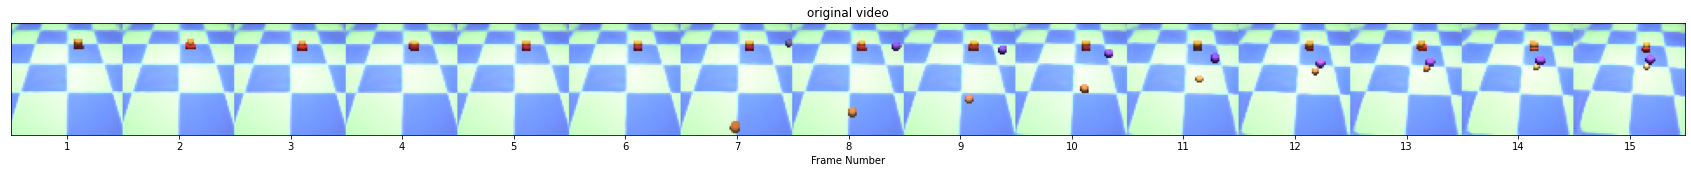

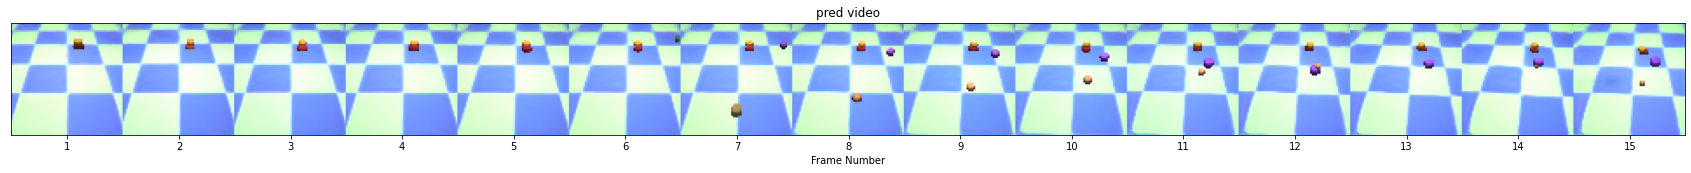

In [13]:
pred_video, pred_mask = pc.video_decoding(perception, pred_latent_code)
p_video = tf.reduce_sum(pred_video[0], axis = -1)
plot_video(video, name = 'original video')
plot_video(p_video, name = 'pred video')

In [24]:
para = ['continuity', 'solidity', 'directional_inertia', 'unchangeableness', 'object_persistence']
test_batch_size = 1
probe_object_persistence  = make_probe_tfrecord_dataset(para[0], shuffle=True)
probe_object_persistence = probe_object_persistence.batch(test_batch_size)
test_ds = probe_object_persistence

In [25]:
def mask_seg(mask):
    """
    preprocess the mask to get the K channels mask for K objects
    input: mask (batch_size, height, width)
    output: mask_seg (batch_size,  height, width, K)
    in our case, K = 8
    """
    mask_seg = tf.one_hot(indices=mask, depth = 8, on_value=1.0, off_value=0.0, axis = 0)
    mask_seg = tf.transpose(mask_seg, perm=[1,2,3,0])
    # print("one-hot mask:", mask_seg.shape)
    return mask_seg


In [39]:
test_example = next(iter(test_ds))
test_example = next(iter(test_ds))
test_example = next(iter(test_ds))
test_example = next(iter(test_ds))
data = test_example

In [41]:
possible_image = data['possible_image']
possible_image = tf.cast(possible_image, tf.float32)
possible_image = possible_image / 255.0
possible_mask = data['possible_mask']
# print("possible_mask",possible_mask.shape)      #[batch_size,2,15,64,64]
B = possible_mask.shape[0]
possible_mask = tf.reshape(possible_mask, [-1, 64, 64])
possible_mask = mask_seg(possible_mask)
# print("mask_seg:",possible_mask.shape)          #[batch_size,2,15,64,64]
possible_mask = tf.reshape(possible_mask, [B,2,15,64,64,8])
possible_mask = tf.cast(possible_mask, tf.float32)
possible_camera_pos = data['possible_camera_pose']
possible_camera_pos = tf.cast(possible_camera_pos, tf.float32)

impossible_image = data['impossible_image']
impossible_image = tf.cast(impossible_image, tf.float32)
impossible_image = impossible_image / 255.0
impossible_mask = data['impossible_mask']
impossible_mask = tf.reshape(impossible_mask, [-1, 64, 64])
impossible_mask = mask_seg(impossible_mask)
impossible_mask = tf.reshape(impossible_mask, [B,2,15,64,64,8])
impossible_mask = tf.cast(impossible_mask, tf.float32)
impossible_camera_pos = data['impossible_camera_pose']
impossible_camera_pos = tf.cast(impossible_camera_pos, tf.float32)

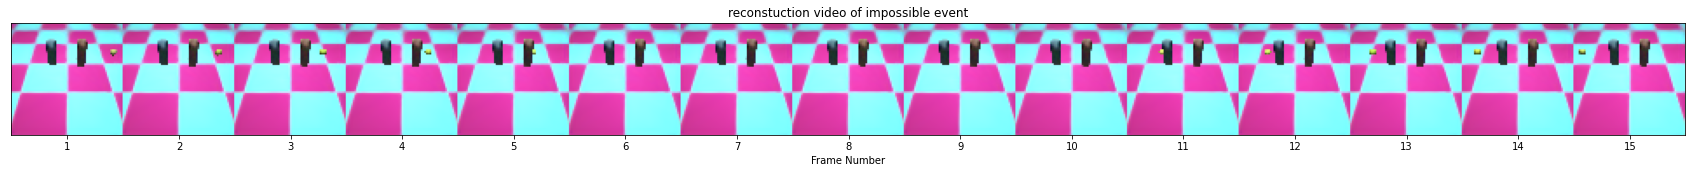

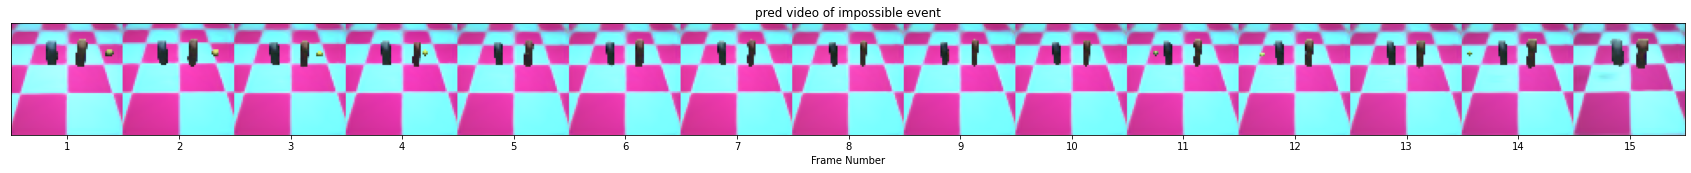

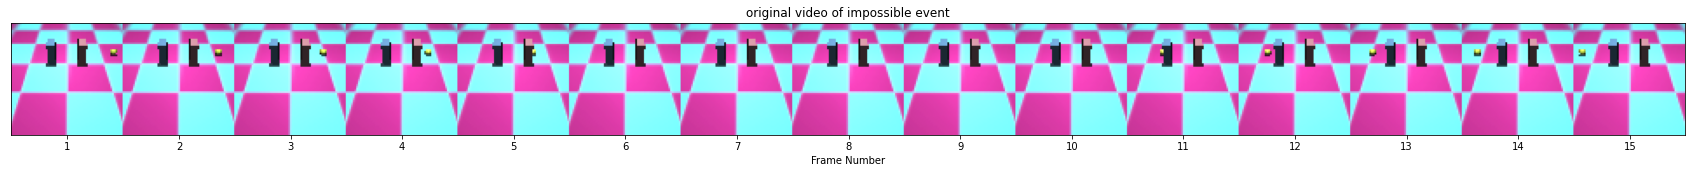

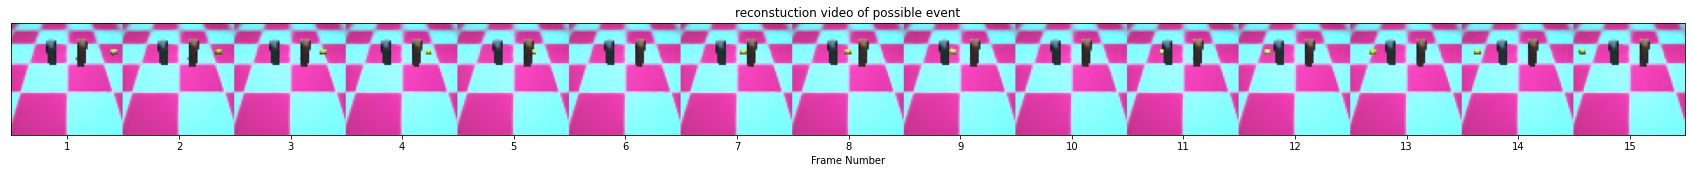

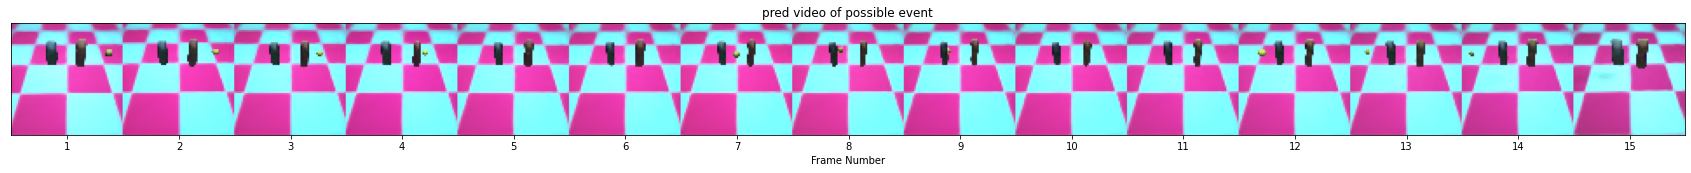

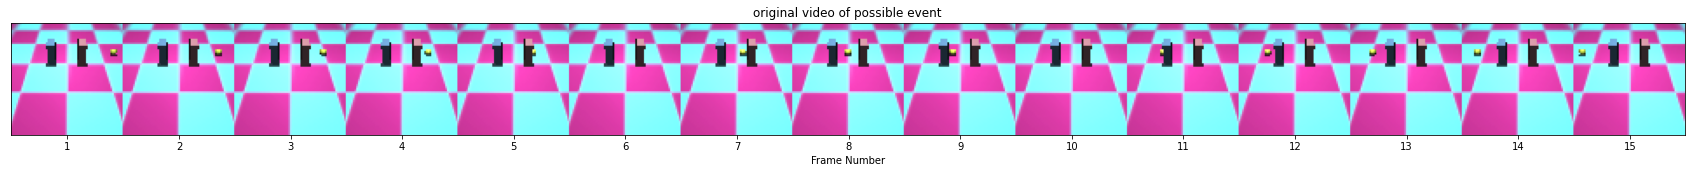

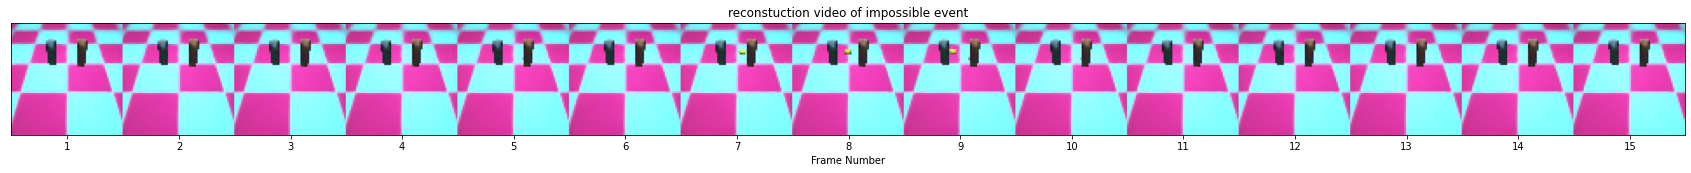

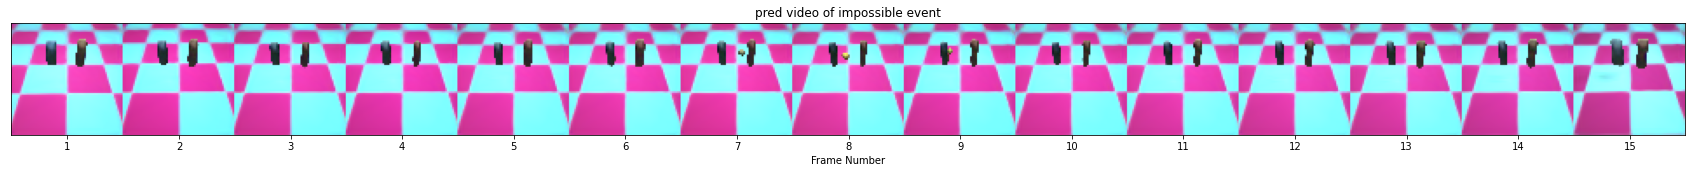

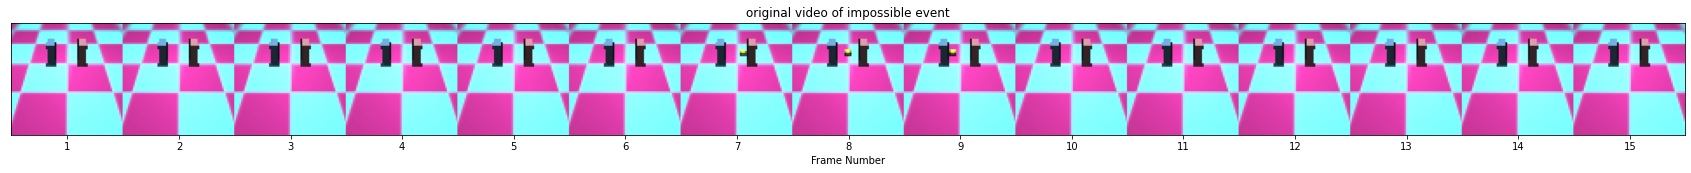

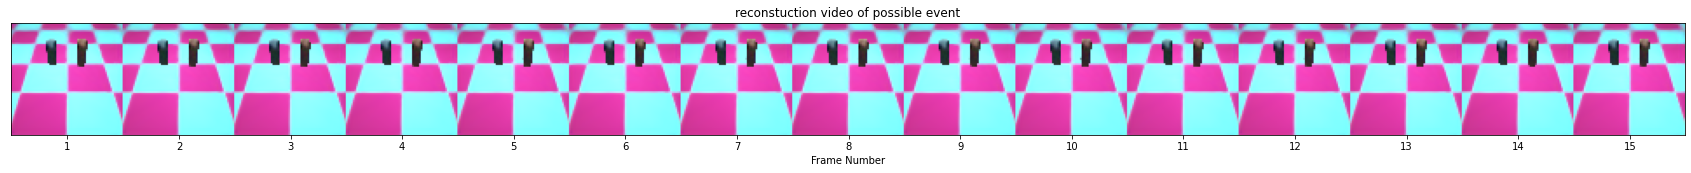

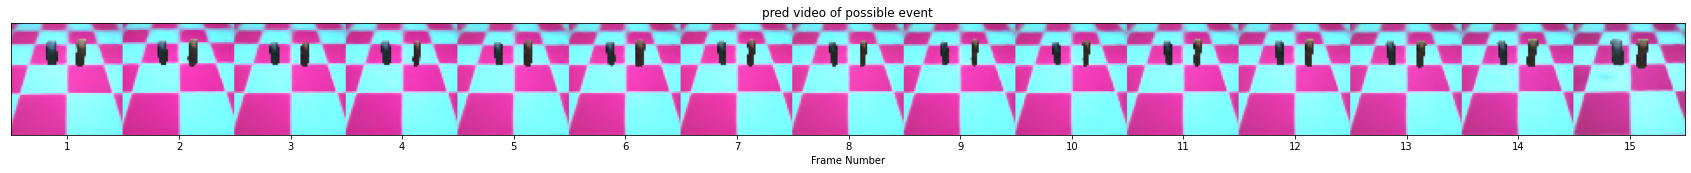

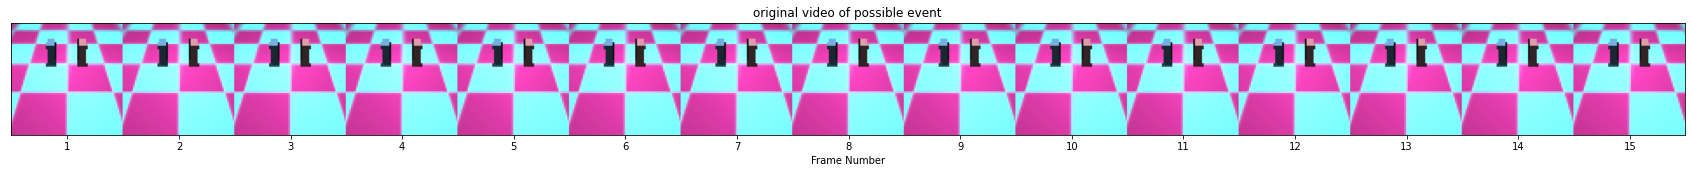

: 

In [42]:

from loss import reconstuction_loss


for i in range(2):
    imp_image = impossible_image[:, i, ...]
    imp_mask = impossible_mask[:, i, ...]
    imp_camera_pos = impossible_camera_pos[:, i, ...]
    
    imp_latent_code = pc.video_encoding(perception, imp_image, imp_mask)
    imp_pred_latent_code = lstm(imp_latent_code, imp_camera_pos)
    imp_pred_video, imp_pred_mask = pc.video_decoding(perception, imp_pred_latent_code)            
    # p_pred_video = p_pred_video[:, :num_frames-1, :, :, :]
    # p_image = p_image[:, 1:, :, :, :]
    imp_pred_video = tf.reduce_sum(imp_pred_video, axis = -1)
    
    imp_reconstruct, _ = pc.video_decoding(perception, imp_latent_code)
    imp_reconstruct = tf.reduce_sum(imp_reconstruct, axis = -1)
    
    plot_video(imp_reconstruct[0], name='reconstuction video of impossible event')
    plot_video(imp_pred_video[0], name='pred video of impossible event')
    plot_video(imp_image[0], name='original video of impossible event')
    
    
    
    p_image = possible_image[:, i, ...]
    p_mask = possible_mask[:, i, ...]
    p_camera_pos = possible_camera_pos[:, i, ...]
    
    p_latent_code = pc.video_encoding(perception, p_image, p_mask)
    p_pred_latent_code = lstm(p_latent_code, p_camera_pos)
    p_pred_video, p_pred_mask = pc.video_decoding(perception, p_pred_latent_code)            
    # p_pred_video = p_pred_video[:, :num_frames-1, :, :, :]
    # p_image = p_image[:, 1:, :, :, :]
    p_pred_video = tf.reduce_sum(p_pred_video, axis = -1)
    
    p_reconstuct, _ = pc.video_decoding(perception, p_latent_code)
    p_reconstuct = tf.reduce_sum(p_reconstuct, axis = -1)
    
    plot_video(p_reconstuct[0], name='reconstuction video of possible event')
    plot_video(p_pred_video[0], name='pred video of possible event')
    plot_video(p_image[0], name='original video of possible event')

    # print("original reconstruction error of impossible event:", loss.video_reconstuction_loss(imp_reconstruct, imp_image))
    # print("reconstuction_loss of impossible event:", loss.video_reconstuction_loss(imp_pred_video, imp_image))
    # print("original reconstruction error of possible event:", loss.video_reconstuction_loss(p_reconstuct, p_image))
    # print("reconstuction_loss of possible event:", loss.video_reconstuction_loss(p_pred_video, p_image))
    